In [19]:
#modules and packages
#!pip install arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.graphics.tsaplots as sgt
from arch import arch_model
BOLD = '\033[1m'
END = '\033[0m'
warnings.filterwarnings('ignore')

In [6]:
#Prepare data
raw_data = pd.read_csv('Index2018.csv')
data = raw_data.copy()

#date as index
data.date = pd.to_datetime(data.date, dayfirst=True)
data.set_index('date', inplace=True)
data = data.asfreq('b')
data = data.fillna(method='ffill')
data['market_value'] = data.ftse
data['returns'] = data.market_value.pct_change(1).mul(100)
data['sq_rets'] = data.returns.mul(data.returns)
del data['ftse']

#split
size = int(len(data)*.8)
train = data.iloc[:size]
test = data.iloc[size:]

### ARCH Models
Autoregressive Conditional Heteroskedasticity models =  measure volatility/variance in a time series. The model is conditional because we are measuring variance dependent on other values using past values to measure variance (autoregressive). I.e. **we are measuring variance now conditional on the variance of past seasons**. Goal is to have low variance because stability is good. The models contain two equations:
- Mean equation: base model with which to set expectations for in order to measure the variance with. It can be measured with an ARMAX model.
- Variance equation: model to measure the unexpected shock/deviation from the mean model equation

In two equation representation, the mean model is used to estimate the time series observation based on the data. The residual values from this model are then used to estimate the variance model.

ARCH(q) where q = number of previous values we include in the model. This is denoted with a **p** in the arch_model() function

**Volatility** numeric measure of uncertainty which is what ARCH models try to measure. Features include:
- May not be directly observable and evolves continuously, - it doesnt go off to infinity which is why we use stationary data to avoid data explosion, but when we dont have stationary data, we can achieve this through integration.
- It reacts differently to big increases and big fails.  


**Volatility clustering** = the observation that low measures are followed by low measures, and high measures are followed by high measures in a series.

**Optimal number of lags**: We can examine the PACF and squared PACF of the time series to see how many lags to include.

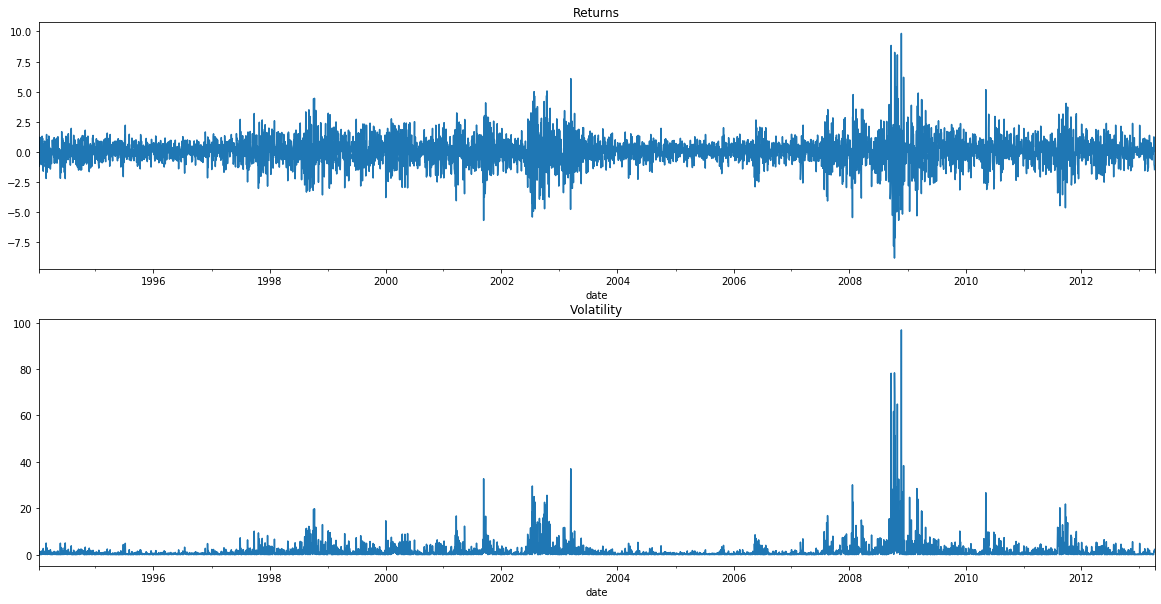

In [11]:
#Raw Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,10))
train.returns.plot(ax=ax1)
train.sq_rets.plot(ax=ax2)
ax1.title.set_text('Returns')
ax2.title.set_text('Volatility')
plt.show()

Note: the periods with high returns have high volatility/uncertainty while those with low returns have low volatility/uncertainty

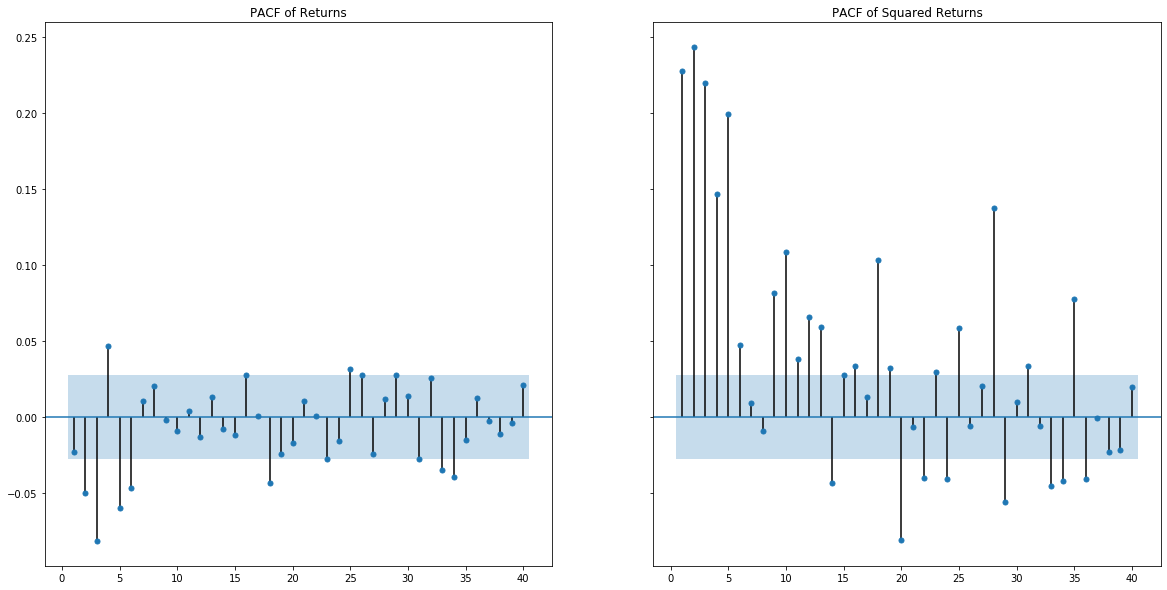

In [16]:
#PACF plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10), sharey=True)
sgt.plot_pacf(train.returns[1:], lags=40, alpha=0.05, zero=False, method='ols', ax=ax1)
sgt.plot_pacf(train.sq_rets[1:], lags=40, alpha=0.05, zero=False, method='ols', ax=ax2)
ax1.title.set_text('PACF of Returns')
ax2.title.set_text('PACF of Squared Returns')
plt.show()

We look at the squared values to get an idea of which lags are significant so that we can get insight on how the data performs even when we cant get number of optimal lags. First few lags are significant with coefficients close to each other which suggests clustering (high variation follows high variation and vice versa). The shorter variance in significant coefficients means there are short term trends in variance i.e. things tend to change often between high and low/ rather they dont stay the same forever (we noted earlier that variance evolves continously) so our data seems to follow a few characteristics of volatility and so it makes sense.

### Simple ARCH(1) Model:

### Interpretation:  
Iteration Table: Shows all attempts to fit the model and measure log likelihood. The fitting only stops after the log likelihood has decreased to certain extent. If the decreasing factor is not growing by a threshold of significance, the iterations stop running. **If you dont want to observe all the iterations,** you can set update_freq != 1 in the fit() function

Summary table has three sections:  
#### Constant Mean GARCH Model Results
- Mean Model: Constant mean = implies mean is constant
- Variance Model: different model for variance equation
- Distribution: = distribution of the residuals
- Method: = how we find the coefficients
- DF Model: = number of degrees of freedom/coefficients that this model has

#### Mean Model
- mu: = coefficient of mean model

#### Volatility Model
- omega: = constant coefficient of the variance model
- alpha: = coefficient of the squared error term
- beta: = ....

In [22]:
#ARCH(1) model
model_arch_1 = arch_model(train.returns[1:], mean='Constant', vol='ARCH', p=1)
model_arch_1.fit(update_freq=10).summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7660.08878204096
            Iterations: 6
            Function evaluations: 39
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Sat, Apr 11 2020   Df Residuals:                     5017
Time:                        19:10:18   Df Model:                            3
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

- THe lower the number of iterations, the simpler our model is
- RSQ/Adjused RSQ --> -0 means the value is negative but its absolute value is so minute so we should round it up to zero. Also a constant model mean doesnt have actual variance which is why we dont have variance explained when we look at the R-SQ
- Log Likelihood --> Relatively smaller compared to ARIMAX type models.
- We should have three coefficients: The mean model constant, the variance model constant, and the variance squared error term constant
- **Note:** Even though the ARCH model seems to be the best estimator for our data based on its log likelihood value, this family of models can only be used to predict **future variance** rather than future returns

### Homework:
- Predict models with different mean specfications e.g.AR, Zero. If you say mean="AR",make sure to include a lags argument. You can use the returns PACF to see which lags to include e.g. lags = [1,2,4]
- Practice with different error distributions by adding the argument dist = 'ged' FOR generalized error distribution or dist = 't' for t-distribution

### Higher Order ARCH Models

In [23]:
model_arch_2 = arch_model(train.returns[1:], mean='Constant', vol='ARCH', p=2)
model_arch_2.fit(update_freq=10).summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7449.545164098214
            Iterations: 9
            Function evaluations: 67
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Sat, Apr 11 2020   Df Residuals:                     5016
Time:                        19:28:09   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

In [24]:
model_arch_3 = arch_model(train.returns[1:], mean='Constant', vol='ARCH', p=3)
model_arch_3.fit(update_freq=10).summary()

Iteration:     10,   Func. Count:     84,   Neg. LLF: 7277.050453152619
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7277.050452148393
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -7277.05
Distribution:                  Normal   AIC:                           14564.1
Method:            Maximum Likelihood   BIC:                           14596.7
                                        No. Observations:                 5020
Date:                Sat, Apr 11 2020   Df Residuals:                     5015
Time:                        19:28:41   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0529  1.316e-02      4.018  5.875e-05 [2.707e-02,7.865e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5012  2.834e-02     17.685  5.505e-70 [  0.446,  0.557]
alpha[1]       0.1570  2.649e-02      5.926  3.108e-09 [  0.105,  0.209]
alpha[2]       0.2197  2.588e-02      8.489  2.077e-17 [  0.169,  0.270]
alpha[3]       0.2804  3.354e-02      8.359  6.302e-17 [  0.215,  0.346]
========================================================================

Covariance estimator: robust
"""

We keep increasing the number of lags until we come across a model where not all the coefficients are significant. This is achieved at ARCH(13) model in this example. 

Note that the log likelihood keeps increasing and AIC keeps decreasing but there are diminishing changes as the order of models increases. Next we look at how we can include past values as an independent variable in the ARCH model.

### ARMA - ARCH Model = GARCH Model
Involves including an AR equivalent component of ARCH model in the model we are estimating. Since the estimators here are squared residual/variance, we include conditional variances of past periods in our ARCH model so that the variance model is now of **conditional variance of this period conditional on that of a past period**. This type of model is called the GARCH model (g= generalized). It accounts for including past conditional variances (which already contain the squared error terms of the previous period making their addition redundant).

### Similarities between GARCH and ARMA
- They both have two orders: GARCH = GARCH (past conditional variances) and ARCH (past squared residuals) ; ARMA (past values = AR, and past residuals = MA)
- Notation orders: ARMA(p,q) and GARCH(p,q). When combined, the mean equation contains the ARMA(p,q) component and the variance equation has the GARCH(p,q) component where the p,q for each segment do not have to match

### Simple GARCH(1,1) Model
We fit a GARCH(1,1) model with serially uncorrelated data which means that the model does not rely on past values or errors i.e. a constant mean model. Note: In python the GARCH(p,q) => ARCH(p) and GARCH(q)

In [26]:
model_garch_1_1 = arch_model(train.returns[1:], mean='Constant', vol='GARCH',p=1, q=1)
model_garch_1_1.fit(update_freq=10).summary()

Iteration:     10,   Func. Count:     73,   Neg. LLF: 6970.088043671654
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366189876
            Iterations: 13
            Function evaluations: 91
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Sat, Apr 11 2020   Df Residuals:                     5016
Time:                        19:51:15   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

Note that the LLF value went up again, even higher than when we added a lot of p lags. This means including past conditional variances along with the squared residuals has more accuracy/predictive power. This is like going from MA (compare past squared residuals alone to past errors) to ARMA (compare past conditional variances to past values).

**For the time being, this model is our new front runner compared to the ARCH model** when it comes to measuring volatility. Now we can go higher order models to see if they are better

### Higher Order GARCH(p,q) Models
Before we begin => mathematically proven that no higher order GARCH model outperforms the GARCH(1,1) model in predicting future returns because of the redundancy of including past residuals. i.e. all past effects can be captured in the immediate past period's conditional variance so you only need to have the t-1 component for the optional choice for analysing returns.

In [27]:
#GARCH(1,2)
model_garch_1_1 = arch_model(train.returns[1:], mean='Constant', vol='GARCH',p=1, q=2)
model_garch_1_1.fit(update_freq=10).summary()

Iteration:     10,   Func. Count:     80,   Neg. LLF: 6970.063553697997
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.058366227228
            Iterations: 12
            Function evaluations: 95
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13950.1
Method:            Maximum Likelihood   BIC:                           13982.7
                                        No. Observations:                 5020
Date:                Sat, Apr 11 2020   Df Residuals:                     5015
Time:                        20:01:00   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.184e-02      3.938  8.219e-05 [2.341e-02,6.982e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  2.908e-03      3.761  1.696e-04 [5.236e-03,1.663e-02]
alpha[1]       0.0835  1.189e-02      7.019  2.231e-12   [6.017e-02,  0.107]
beta[1]        0.9089      0.188      4.845  1.268e-06     [  0.541,  1.277]
beta[2]        0.0000      0.180      0.000      1.000     [ -0.352,  0.352]
============================================================================

Covariance estimator: robust
"""

In [28]:
#GARCH(1,3)
model_garch_1_3 = arch_model(train.returns[1:], mean='Constant', vol='GARCH',p=1, q=3)
model_garch_1_3.fit(update_freq=10).summary()

Iteration:     10,   Func. Count:     97,   Neg. LLF: 6972.43119644999
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6970.05836623016
            Iterations: 17
            Function evaluations: 154
            Gradient evaluations: 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13952.1
Method:            Maximum Likelihood   BIC:                           13991.2
                                        No. Observations:                 5020
Date:                Sat, Apr 11 2020   Df Residuals:                     5014
Time:                        20:05:17   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.179e-02      3.954  7.683e-05 [2.351e-02,6.972e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0109  8.157e-03      1.341      0.180 [-5.052e-03,2.692e-02]
alpha[1]       0.0835  6.059e-02      1.378      0.168   [-3.528e-02,  0.202]
beta[1]        0.9089      2.148      0.423      0.672      [ -3.301,  5.119]
beta[2]        0.0000      3.375      0.000      1.000      [ -6.614,  6.614]
beta[3]    3.9718e-13      1.294  3.070e-13      1.000      [ -2.536,  2.536]
=============================================================================

Covariance estimator: robust
"""

In [29]:
#GARCH(2,1)
model_garch_2_1 = arch_model(train.returns[1:], mean='Constant', vol='GARCH',p=2, q=1)
model_garch_2_1.fit(update_freq=10).summary()

Iteration:     10,   Func. Count:     85,   Neg. LLF: 6967.735886702618
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6967.731020076142
            Iterations: 12
            Function evaluations: 99
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -6967.73
Distribution:                  Normal   AIC:                           13945.5
Method:            Maximum Likelihood   BIC:                           13978.1
                                        No. Observations:                 5020
Date:                Sat, Apr 11 2020   Df Residuals:                     5015
Time:                        20:06:51   Df Model:                            5
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.187e-02      3.922  8.780e-05 [2.329e-02,6.982e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0129  4.097e-03      3.158  1.589e-03  [4.908e-03,2.097e-02]
alpha[1]       0.0547  1.665e-02      3.286  1.017e-03  [2.208e-02,8.735e-02]
alpha[2]       0.0389  2.345e-02      1.659  9.709e-02 [-7.056e-03,8.488e-02]
beta[1]        0.8974  1.712e-02     52.415      0.000      [  0.864,  0.931]
=============================================================================

Covariance estimator: robust
"""

Note we have multicollinearity for the nth variable because of the relationship we explained with returns above. In essence, if p, q > 1, the model's highest order variables will be insignificant at 5% level so you will always end up with GARCH(1,1) as the optimal choice for predicting future returns